# Seminar 4. Locomotion control
## Plan
* Create locomotory CPG for a hexapod
* Create walking CPG for bipedal walking
* Create control system for BipedalWalker environment

## Homework
* Switch rhythms of hexapod CPG by neuromodulation of synaptic weights
* Tune walking CPG parameters to obtain the desired frequency and phase lags

## Materials
Russell, A., Orchard, G., & Etienne-Cummings, R. (2007, May). Configuring of spiking central pattern generator networks for bipedal walking using genetic algorthms. In 2007 IEEE International Symposium on Circuits and Systems (pp. 1525-1528). IEEE.



## 1. Create CPG of Adaptive LIF neurons

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

def plot_v_spikes(v_mon, s_mon, t_bounds=None, names=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    for i in range(len(v_mon.v)):
        if names:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=names[i])
        else:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=f'N_{i}')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

N = 4
V_REST = 1.5
TAU_V = 10 * b2.ms
V_RESET = 0
VT_0 = 1
TAU_T = 20 * b2.ms
THETA = 0.1
W_SYN = -1

def alif_group(num_neurons, v_rest=V_REST,tau_v=TAU_V, 
               v_reset=V_RESET, vt_0=VT_0, 
               tau_t=TAU_T, theta=THETA):
    eqs = '''
        dv/dt = (v_rest-v)/tau_v : 1
        dvt/dt = (vt_0-vt)/tau_t : 1
        tau_v : second
        v_rest : 1
        v_reset : 1
        vt_0 : 1
        tau_t : second
        theta : 1
        '''
    reset = '''
        v = v_reset
        vt += theta
        '''
    G = b2.NeuronGroup(num_neurons, model=eqs, reset=reset, threshold='v>vt',
                 method='linear')
    G.tau_v = tau_v
    G.v_rest = v_rest
    G.v_reset = v_reset
    G.vt_0 = 'rand()'
    G.tau_t = tau_t
    G.theta = theta
    G.vt = v_rest
    return G

class CPG:
    
    def __init__(self):
        self.N = 4
        self.neurons = alif_group(self.N)
        self.spike_mon = b2.SpikeMonitor(self.neurons)
        self.v_mon = b2.StateMonitor(self.neurons, "v", record=True)
        self.create_synapses()
        self.net = b2.Network(self.neurons, self.synapses, self.spike_mon, self.v_mon)
            
    def create_synapses(self):
        self.synapses = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        self.synapses.connect(i=0, j=1)
        self.synapses.connect(i=1, j=0)
        self.synapses.connect(i=1, j=2)
        self.synapses.connect(i=2, j=1)
        self.synapses.connect(i=2, j=3)
        self.synapses.connect(i=3, j=2)
        

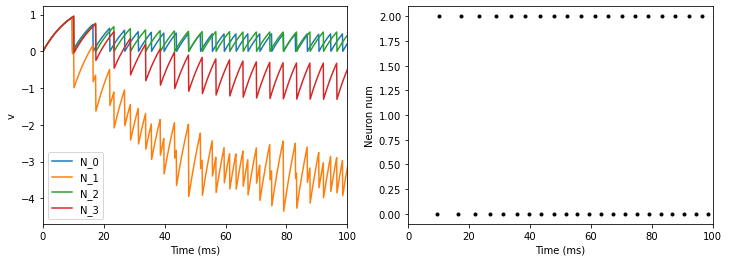

In [69]:
b2.start_scope()
cpg = CPG()
#PG = b2.PoissonGroup(1, 10*1/TAU_V)
cpg.net.run(500 * b2.ms, namespace={'w_syn':W_SYN})
plot_v_spikes(cpg.v_mon, cpg.spike_mon, [0,100])